In [1]:
import cv2
import numpy as np
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from pyefd import elliptic_fourier_descriptors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

In [53]:
class MalformPrediction:
    """
    Class to predict if a contour of the potatois a malformation or not.
    """
    def __init__(self, model_location: str):
        # Load the KMeans model
        # Takes the model path as input
        with open(model_location, 'rb') as f:
            self.kmeans = pickle.load(f)


    def __read_images_and_extract_contours_single_image(self, img_location):
        """Read images from a folder and extract their largest external contour."""
        self.images = img_location
        self.contours_list = []
        for image_path in self.images:
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            self.contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if self.contours:
                contour = max(self.contours, key=cv2.contourArea)
                contour = contour.squeeze()
                self.contours_list.append(self.__normalize_contour_points(contour))
        return self.contours_list

    def __normalize_contour_points(self, contour):
        """Normalize contour points to a fixed number for consistency."""
        self.N = 250
        self.contour_length = np.linspace(0, 1, len(contour))
        self.normalized_length = np.linspace(0, 1, self.N)
        self.interp_func_x = interp1d(self.contour_length, contour[:, 0], kind='linear')
        self.interp_func_y = interp1d(self.contour_length, contour[:, 1], kind='linear')
        self.normalized_contour = np.vstack((self.interp_func_x(self.normalized_length), self.interp_func_y(self.normalized_length))).T
        return self.normalized_contour

    def __compute_fourier_coefficients(self,contour, order=30):
        """Compute Fourier coefficients for a given contour."""
        self.coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
        #return coeffs[1:]  # Skip the first coefficient as it's related to the image position
        return self.coeffs

    def __compute_class_averages(self, fourier_descriptors, labels, n_clusters):
        """Compute average Fourier coefficients for each cluster."""
        self.sums = [np.zeros(fourier_descriptors[0].shape) for _ in range(n_clusters)]
        self.counts = [0] * n_clusters
        for coeffs, label in zip(fourier_descriptors, labels):
            self.sums[label] += coeffs
            self.counts[label] += 1
        self.averages = [self.sums[i] / self.counts[i] if self.counts[i] > 0 else None for i in range(n_clusters)]
        return self.averages

    def __inverse_fourier_transform(self, coeffs, num_points=500, H=30):
        """Reconstruct a shape from its Fourier coefficients."""
        self.X, self.Y = np.zeros(num_points), np.zeros(num_points)
        self.t_values = np.linspace(0, 2 * np.pi, num_points, endpoint=True)
        for h in range(H):
            self.X += coeffs[h, 0] * np.cos((h+1) * self.t_values) + coeffs[h, 1] * np.sin((h+1) * self.t_values)
            self.Y += coeffs[h, 2] * np.cos((h+1) * self.t_values) + coeffs[h, 3] * np.sin((h+1) * self.t_values)
        return np.vstack((self.X, self.Y)).T

    def predict_cluster(self, image_path, order=30):
        """Predicts the cluster for a single image and returns its label and average shape. Useful for plotting."""
        self.contour = self.__read_images_and_extract_contours_single_image([image_path])[0]
        self.fourier_coeffs = self.__compute_fourier_coefficients(self.contour, order=order).flatten()
        self.cluster_label = self.kmeans.predict([self.fourier_coeffs])[0]
        self.class_averages = self.__compute_class_averages([self.fourier_coeffs], [self.cluster_label], self.kmeans.n_clusters) # Compute the average shape for the cluster
        self.avg_shape = self.__inverse_fourier_transform(self.class_averages[self.cluster_label].reshape(order, -1), H=order) # Reconstruct the average shape
        return self.cluster_label, self.avg_shape # not doing +1 here to match the cluster number with the cluster label
    

    def plot_predicted_clusters(self, predicted_cluster, avg_shape, image_to_predict_path):
        """Plot the input image and the average shape of the predicted cluster."""
        plt.ion()
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Show the image
        img = cv2.imread(image_to_predict_path)
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Input Image')
        axes[0].axis('off')  # Turn off axis for the image
        
        #Show the average shape of the associated cluster
        axes[1].plot(avg_shape[:, 0], avg_shape[:, 1])
        axes[1].set_title(f'Predicted Cluster: {predicted_cluster + 1}')
        axes[1].axis('equal')
        axes[1].set_aspect('equal')

        plt.show()

    def prediction_cluster_value(self, image_path, order=30):
        """Predicts the cluster for a single image and returns its label no only."""
        self.contour = self.__read_images_and_extract_contours_single_image([image_path])[0]
        self.fourier_coeffs = self.__compute_fourier_coefficients(self.contour, order=order).flatten()
        self.cluster_label = self.kmeans.predict([self.fourier_coeffs])[0]
        self.class_averages = self.__compute_class_averages([self.fourier_coeffs], [self.cluster_label], self.kmeans.n_clusters) # Compute the average shape for the cluster
        self.avg_shape = self.__inverse_fourier_transform(self.class_averages[self.cluster_label].reshape(order, -1), H=order) # Reconstruct the average shape
        return self.cluster_label + 1 # only returns cluster value with +1 to match the cluster number with the cluster label


In [54]:
potato_formation = MalformPrediction('kmeans_model.pkl')

NameError: name 'image_path' is not defined

In [55]:
image_to_predict_path = '/home/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/bottleneck/sd_malformed_12_2_1_100_10.png'

In [56]:
potato_formation.prediction_cluster_value(image_to_predict_path, order=30)

24

In [35]:
predicted_cluster, avg_shape = potato_formation.predict_cluster(image_to_predict_path)

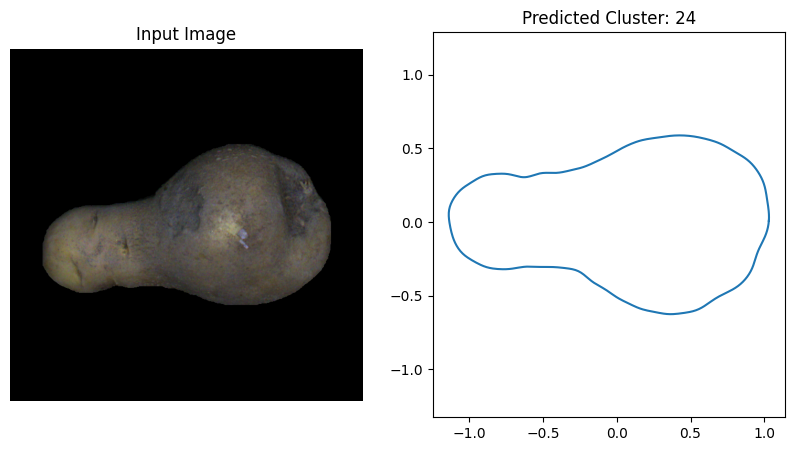

In [36]:
potato_formation.plot_predicted_clusters(predicted_cluster, avg_shape, image_to_predict_path)